## Sampling
In this notebook we perform the generation. You need to set the loaded file name as the model trained in the previous cell. The sampling methods from trans_tdsm.py are again used for the sampling. This cell will also provide the inputs needed for plots at various stages of the diffusion. If you want plots in the non-transformed space, you need to add include the names for the transformer pickle files.

Let's first set the environment and the various parameters for the model, hyperparameters, diffusion equations etc.

In [1]:
import time, functools, torch, os,sys, random, fnmatch, psutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam,RAdam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from prettytable import PrettyTable
import tqdm
from pickle import load
from IPython import display
sys.path.insert(1, '../')
import util.data_utils as utils
import util.score_model as score_model
import util.samplers as samplers
import util.display
import util.sdes as sdes

# GPU device info
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:516"
os.system('nvidia-smi')

# Set padding value used
padding_value = 0.0

dataset = "dataset_2_padded_nentry"
preproc_dataset_name = 'ds2_diff_transforms'
dataset_store_path = os.path.join("/eos/user/j/jthomasw/tdsm_encoder/datasets/", preproc_dataset_name)
transform = None
transform_y = None
mask = True
jupyternotebook = True
workingdir = "./"

### SDE PARAMETERS ###
SDE = 'VP'
if SDE == 'VP':
    beta_max = 1.0
    beta_min = 0.01
if SDE == 'VE':
    sigma_max = 20.0
    sigma_min = 0.1
    
### MODEL PARAMETERS ###
n_feat_dim = 4
embed_dim = 512
hidden_dim = 128
num_encoder_blocks = 8
num_attn_heads = 16
dropout_gen = 0

# Instantiate stochastic differential equation
if SDE == 'VP':
    sde = sdes.VPSDE(beta_max=beta_max,beta_min=beta_min, device=device)
if SDE == 'VE':
    sde = sdes.VESDE(sigma_max=sigma_max,sigma_min=sigma_min,device=device)
marginal_prob_std_fn = functools.partial(sde.marginal_prob)
diffusion_coeff_fn = functools.partial(sde.sde)

print('torch version: ', torch.__version__)
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())

print('Working directory: ', workingdir)

# Input files
files_list_ = []
for filename in os.listdir(dataset_store_path):
    if fnmatch.fnmatch(filename, dataset + '*424To564.pt'):
        files_list_.append(os.path.join(dataset_store_path, filename))
print(files_list_)

# Instantiate model
model = score_model.Gen(n_feat_dim, embed_dim, hidden_dim, num_encoder_blocks, num_attn_heads, dropout_gen, marginal_prob_std=marginal_prob_std_fn)
#torch.save(model.state_dict(), 'initial_model.pt') 

t_params = 0
for name_ , para_ in model.named_parameters():
    if not para_.requires_grad: continue
    param = para_.numel()
    t_params+=param

print(f'Sum of trainable parameters: {t_params}')   

Wed Jan  3 09:17:04 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:07.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |   9755MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Studying the diffusion

No we make some plots of our various features in order to study how the diffusion affects our predicitions. Note that for the generated distributions we use the predefined sampler variables that store arrays of the variable at given time steps. One should check these time steps are the ones you wish to study i.e. is 't99' really set to the last time step or did you take more than 100 time steps? In which case, this isn't the end result of the diffusion model.

We plot the mean/averaged properties of the showers as well as the individual hit distributions. This is because with machine learning techniques like these, there is a degree of randomness in the method as the models use probabilities rather than deal in absolutes, so comparison of individual predictions is a recipe for dissapointment.

Files: ['/eos/user/j/jthomasw/tdsm_encoder/datasets/ds2_diff_transforms/dataset_2_padded_nentry424To564.pt']
# showers per file: [100]
file: /eos/user/j/jthomasw/tdsm_encoder/datasets/ds2_diff_transforms/dataset_2_padded_nentry424To564.pt
max_hits: 564


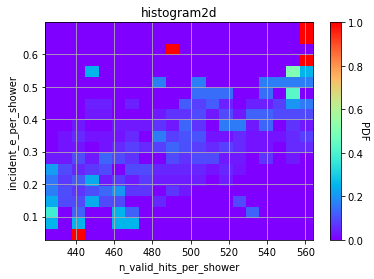

Batch: 0
Generation batch 0: showers per batch: 50, max. hits per shower: 564, features per hit: 4, sampled_energies: 50
Progress: 1/2

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([50, 564, 4])
Batch: 1
Generation batch 1: showers per batch: 50, max. hits per shower: 564, features per hit: 4, sampled_energies: 50
Progress: 2/2

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([100, 564, 4])
sample_: 100, sampled_ine: 100
CPU times: user 29.2 s, sys: 25.4 s, total: 54.6 s
Wall time: 56 s


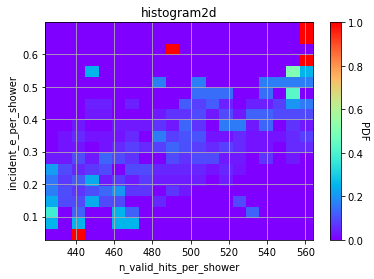

In [5]:
%%time

from IPython import display
from datetime import datetime
import functools, torch, os, sys, random
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tqdm
workingdir = "./"

# Granularity of time steps (defines step size of reverse diffusion)
sampler_steps = 100
# Select time steps for diffusion progression plots
steps2plot = (0, 95, 97, 98, 99)
# Number of showers to generate
n_showers_2_gen = 100
# Batch size for sampler
batch_size = 50

output_directory = workingdir+'/sampling_test_ds2_diff_transforms_'+datetime.now().strftime('%Y%m%d_%H%M')+'_output/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load saved model
#model.load_state_dict(torch.load('/eos/user/j/jthomasw/tdsm_encoder/notebooks/training_20231221_1331_ds2_diff_transforms/ckpt_tmp_199.pth', map_location=device))
model.load_state_dict(torch.load('/eos/user/j/jthomasw/tdsm_encoder/notebooks/training_20240102_2128_ds2_diff_transforms/ckpt_tmp_199.pth', map_location=device))

model.to(device)

geant_hit_energies = []
geant_hit_x = []
geant_hit_y = []

geant_deposited_energy = []
geant_x_pos = []
geant_y_pos = []
geant_ine = np.array([])
N_geant_showers = 0

print(f'Files: {files_list_}')

n_files = len(files_list_)
nshowers_per_file = [n_showers_2_gen//n_files for x in range(n_files)]
r_ = n_showers_2_gen % nshowers_per_file[0]
nshowers_per_file[-1] = nshowers_per_file[-1]+r_
print(f'# showers per file: {nshowers_per_file}')
shower_counter = 0

sample_ = []

# Sampler instance
sampler = samplers.pc_sampler(sde=sde, padding_value=padding_value, snr=0.16, sampler_steps=sampler_steps, steps2plot=steps2plot, device=device, jupyternotebook=True)

# Collect Geant4 shower information
for file_idx in range(len(files_list_)):
    
    # N valid hits used for 2D PDF
    n_valid_hits_per_shower = np.array([])
    # Incident particle energy for 2D PDF
    incident_e_per_shower = np.array([])
    
    max_hits = -1
    file = files_list_[file_idx]
    print(f'file: {file}')
    shower_counter = 0
    
    # Load shower data
    custom_data = utils.cloud_dataset(file, device=device)
    point_clouds_loader = DataLoader(custom_data, batch_size=batch_size, shuffle=True)
    
    # Loop over batches
    for i, (shower_data, incident_energies) in enumerate(point_clouds_loader,0):
        # Copy data
        valid_event = []
        data_np = shower_data.cpu().numpy().copy()
        energy_np = incident_energies.cpu().numpy().copy()
        
        # Mask for padded values
        masking = data_np[:,:,0] != padding_value
        
        # Loop over each shower in batch
        for j in range(len(data_np)):
            
            # valid hits for shower j in batch used for GEANT plot distributions
            valid_hits = data_np[j]
            
            # real (unpadded) hit multiplicity needed for the 2D PDF later
            n_valid_hits = data_np[j][masking[j]]
            
            if len(valid_hits)>max_hits:
                max_hits = len(valid_hits)

            n_valid_hits_per_shower = np.append(n_valid_hits_per_shower, len(n_valid_hits))
            incident_e_per_shower = np.append(incident_e_per_shower, energy_np[j])
            
            # ONLY for plotting purposes
            if shower_counter >= nshowers_per_file[file_idx]:
                break
            else:
                shower_counter+=1

                #geant_ine = np.append(geant_ine, energy_np[j])
                all_ine = energy_np[j].reshape(-1,1)

                # Rescale the conditional input for each shower
                all_ine = all_ine.flatten()
                all_ine = all_ine.tolist()
                geant_ine = np.append(geant_ine,all_ine[0])
                
                all_e = valid_hits[:,0].reshape(-1,1)
                all_e = all_e.flatten().tolist()
                geant_hit_energies.extend(all_e)
                geant_deposited_energy.extend( [sum( all_e )] )
                
                all_x = valid_hits[:,1].reshape(-1,1)
                all_x = all_x.flatten().tolist()
                geant_hit_x.extend(all_x)
                geant_x_pos.extend( [np.mean(all_x)] )
                
                all_y = valid_hits[:,2].reshape(-1,1)
                all_y = all_y.flatten().tolist()
                geant_hit_y.extend(all_y)
                geant_y_pos.extend( [np.mean(all_y)] )

            N_geant_showers+=1

    del custom_data
    print(f'max_hits: {max_hits}')

    # Arrays of Nvalid hits in showers, incident energies per shower
    n_valid_hits_per_shower = np.array(n_valid_hits_per_shower)
    incident_e_per_shower = np.array(incident_e_per_shower)

    # Generate 2D pdf of incident E vs N valid hits from the training file(s)
    n_bins_prob_dist = 20
    e_vs_nhits_prob, x_bin, y_bin = samplers.get_prob_dist(incident_e_per_shower, n_valid_hits_per_shower, n_bins_prob_dist)

    # Plot 2D histogram (sanity check)
    fig0, (ax0) = plt.subplots(ncols=1, sharey=True)
    dh0 = display.display(fig0, display_id=True)
    heatmap = ax0.pcolormesh(y_bin, x_bin, e_vs_nhits_prob, cmap='rainbow')
    ax0.plot(n_valid_hits_per_shower, n_valid_hits_per_shower, 'k-')
    ax0.set_xlim(n_valid_hits_per_shower.min(), n_valid_hits_per_shower.max())
    ax0.set_ylim(incident_e_per_shower.min(), incident_e_per_shower.max())
    ax0.set_xlabel('n_valid_hits_per_shower')
    ax0.set_ylabel('incident_e_per_shower')
    cbar = plt.colorbar(heatmap)
    cbar.ax.set_ylabel('PDF', rotation=270)
    ax0.set_title('histogram2d')
    ax0.grid()
    dh0.update(fig0)

    # Generate tensor sampled from the appropriate range of injection energies
    in_energies = torch.from_numpy(np.random.choice( incident_e_per_shower, nshowers_per_file[file_idx] ))
    if file_idx == 0:
        sampled_ine = in_energies
    else:
        sampled_ine = torch.cat([sampled_ine,in_energies])
    
    # Create variable length tensors of random noise for features of hits
    nhits, gen_hits = samplers.generate_hits(e_vs_nhits_prob, x_bin, y_bin, in_energies, 4, device=device)
    
    # Save
    torch.save([gen_hits, in_energies],'tmp.pt')

    # Load the showers of noise
    gen_hits = utils.cloud_dataset('tmp.pt', device=device)
    
    # Match padding length of training files
    gen_hits.max_nhits = max_hits

    # Pad showers to have equal length
    gen_hits.padding(value=padding_value)
    
    # Load len(gen_hits_loader) number of batches each with batch_size number of showers
    gen_hits_loader = DataLoader(gen_hits, batch_size=batch_size, shuffle=False)

    # Remove noise shower file
    os.system("rm tmp.pt")

    # Load a batch of noise showers
    sample = []
    for i, (gen_hit, sampled_energies) in enumerate(gen_hits_loader,0):
        print(f'Batch: {i}')
        print(f'Generation batch {i}: showers per batch: {gen_hit.shape[0]}, max. hits per shower: {gen_hit.shape[1]}, features per hit: {gen_hit.shape[2]}, sampled_energies: {len(sampled_energies)}')    
        sys.stdout.write('\r')
        sys.stdout.write("Progress: %d/%d" % ((i+1), len(gen_hits_loader)))
        sys.stdout.flush()

        # Run reverse diffusion sampler on showers of random noise + zero-padded hits
        #generative = sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, sampled_energies, gen_hit, batch_size=gen_hit.shape[0])
        generative = sampler(model, sampled_energies, gen_hit, batch_size=gen_hit.shape[0], addmask=1)

        # Create first sample or concatenate sample to sample list
        if i == 0:
            sample = generative
        else:
            sample = torch.cat([sample,generative])

        print(f'sample: {sample.shape}')

    sample_np = sample.cpu().numpy()

    for i in range(len(sample_np)):
        # The output of the sampler has nhits == max hits (do we want to remove these here or during the diffusion?)
        tmp_sample = sample_np[i]#[:nhits[i]]
        sample_.append(torch.tensor(tmp_sample))
        
print(f'sample_: {len(sample_)}, sampled_ine: {len(sampled_ine)}')
torch.save([sample_,sampled_ine], os.path.join(output_directory, 'sample.pt'))

We can make some ineteresting plots of the samples the model generated at various stages of the diffusion process. This can help us debug problems, understand if our choice of SDE parameters is reasonable, study how the number of steps affects our generated sample fidelity etc. 

steps2plot: (0, 95, 97, 98, 99)
sampler.hit_energy_stages[0]: (56400,)

save_name: .//sampling_test_ds2_diff_transforms_20240103_1053_output/Showerindividualhitenergy_perturbation_1D.png
save_name: .//sampling_test_ds2_diff_transforms_20240103_1053_output/Showerindividualhitx_perturbation_1D.png
save_name: .//sampling_test_ds2_diff_transforms_20240103_1053_output/Showerindividualhity_perturbation_1D.png
plt.axis(): (0.0, 6.3, 0.32711830735206604, 0.5073202239706162)
save_name: .//sampling_test_ds2_diff_transforms_20240103_1053_output/ShowerSumX_ShowerSumY.png
plt.axis(): (0.0, 5.25, 120.50930786132812, 179.72258603572845)
save_name: .//sampling_test_ds2_diff_transforms_20240103_1053_output/ShowerSumX_TotaldepositedenergyGeV.png
plt.axis(): (0.0, 7.35, 0.027915043756365776, 0.6984119415283203)
save_name: .//sampling_test_ds2_diff_transforms_20240103_1053_output/Totaldepositedenergy_IncidentparticleenergyGeV.png


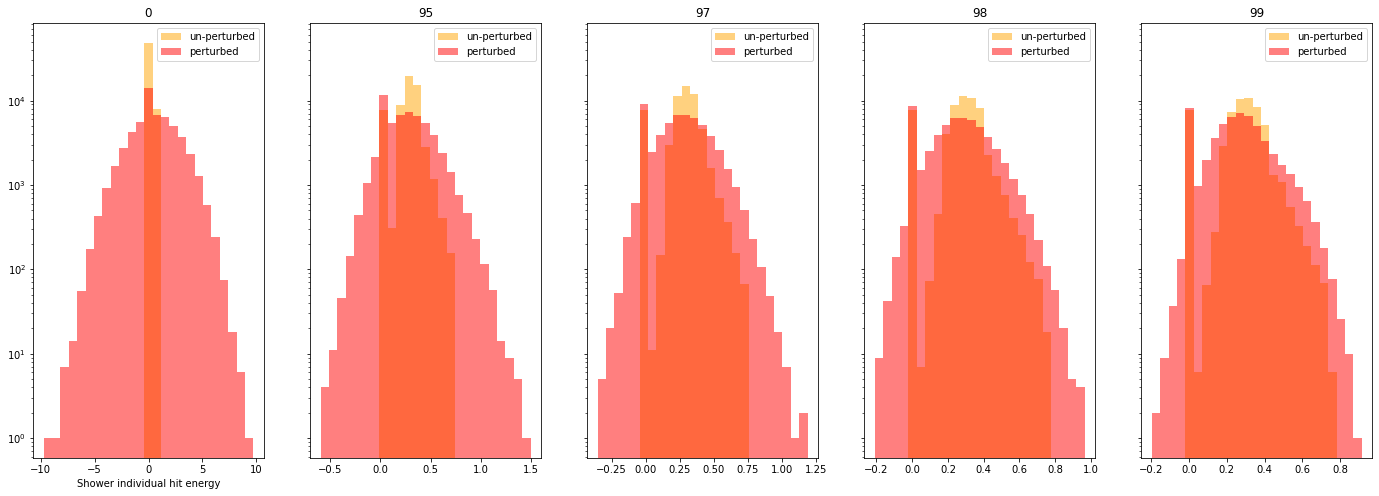

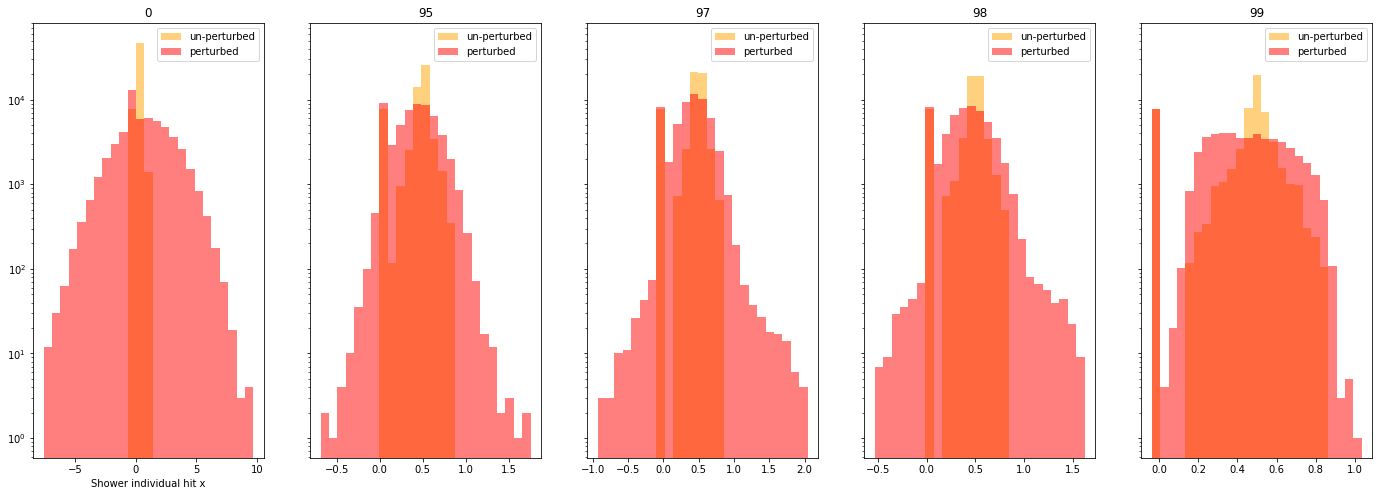

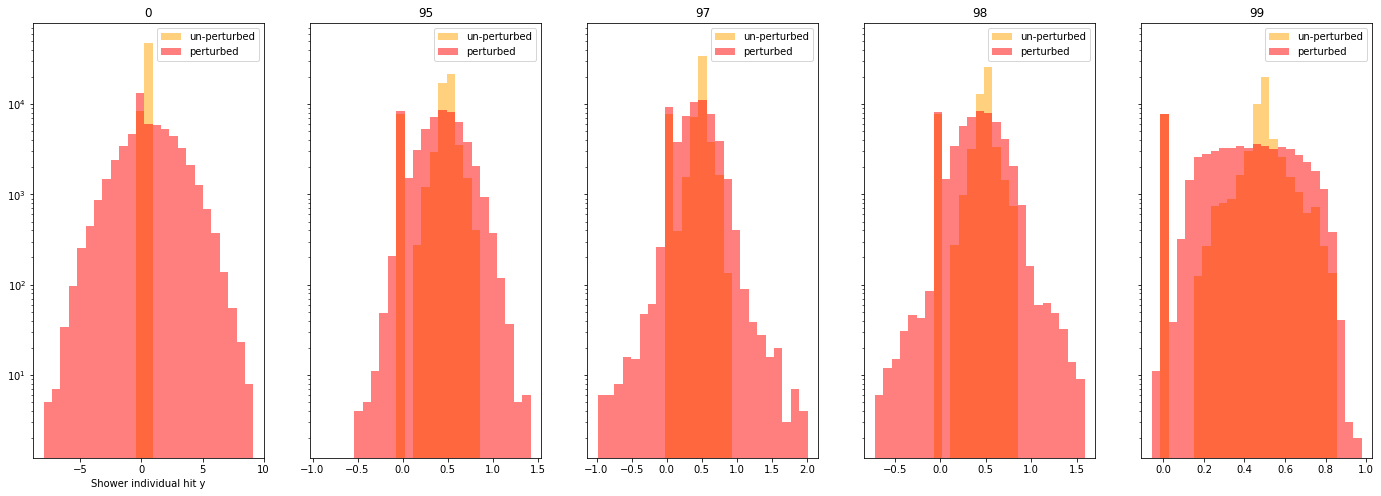

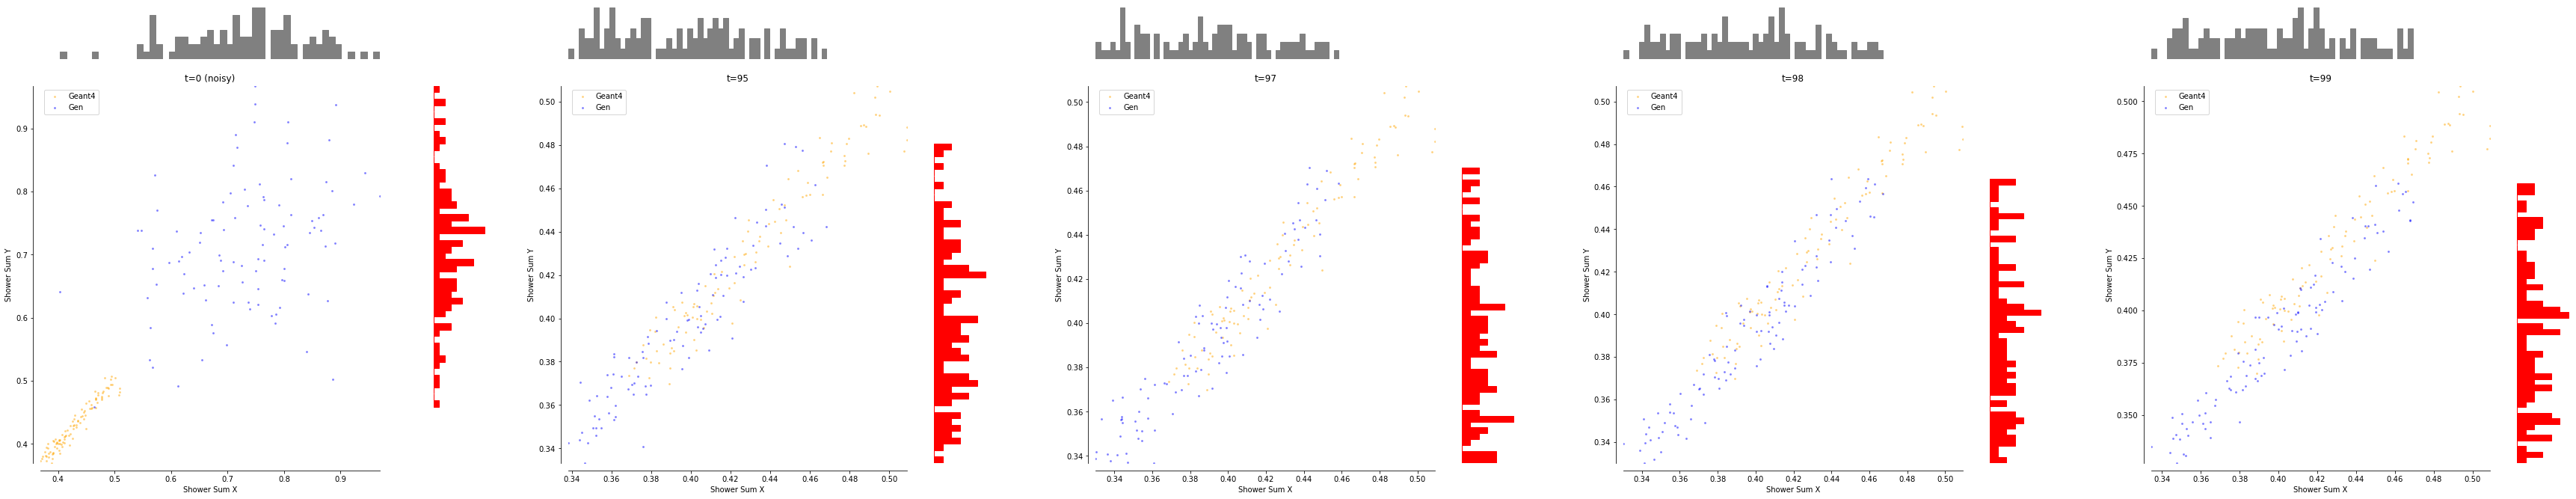

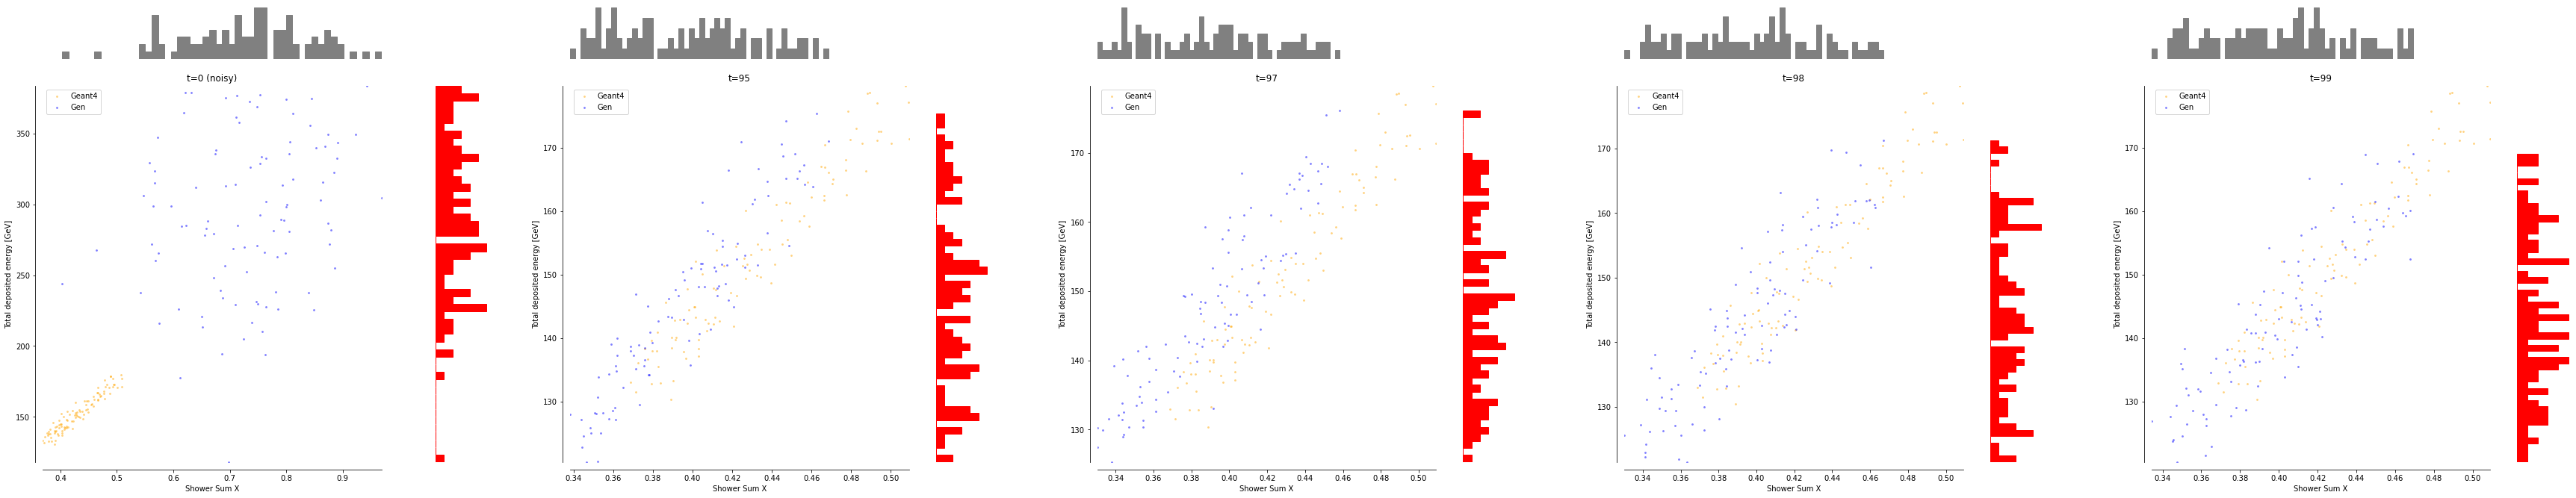

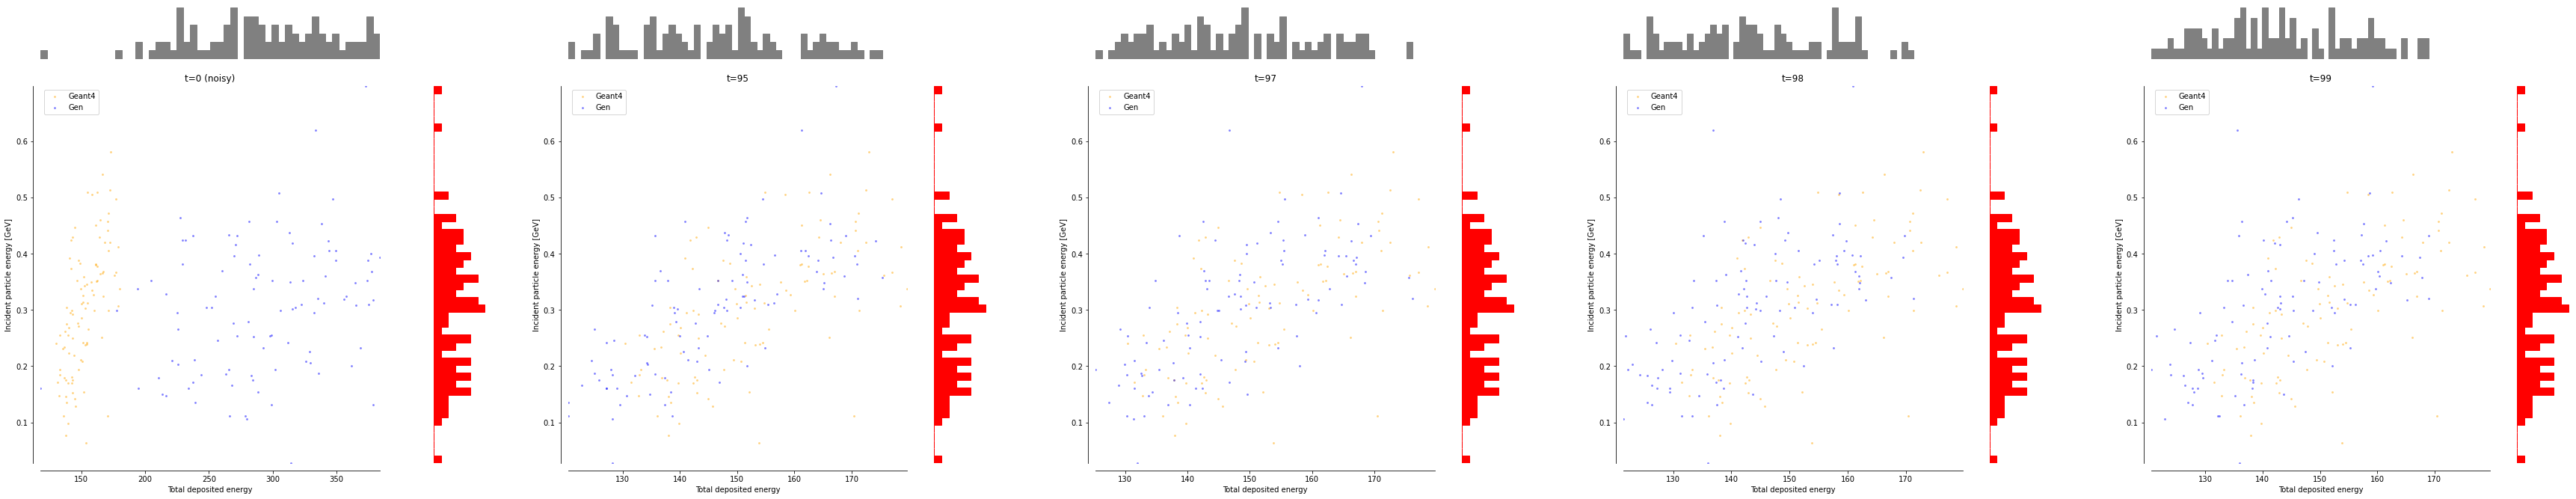

In [6]:
# Create plots of distributions evolving with diffusion steps
step_0 = sampler.steps2plot[0]
print(f'steps2plot: {sampler.steps2plot}')
titles = []
for key, value in sampler.hit_energy_stages.items():
    titles.append(str(key))
print(f'sampler.hit_energy_stages[0]: {np.array(sampler.hit_energy_stages[0]).shape}\n')

distributions = [(('Shower individual hit energy') , (geant_hit_energies, sampler.hit_energy_stages[sampler.steps2plot[0]], sampler.hit_energy_stages[sampler.steps2plot[1]], sampler.hit_energy_stages[sampler.steps2plot[2]], sampler.hit_energy_stages[sampler.steps2plot[3]], sampler.hit_energy_stages[sampler.steps2plot[4]]))]
util.display.perturbation_1D(distributions, titles, output_directory)

distributions = [(('Shower individual hit x') , (geant_hit_x, sampler.hit_x_stages[sampler.steps2plot[0]], sampler.hit_x_stages[sampler.steps2plot[1]], sampler.hit_x_stages[sampler.steps2plot[2]], sampler.hit_x_stages[sampler.steps2plot[3]], sampler.hit_x_stages[sampler.steps2plot[4]]))]
util.display.perturbation_1D(distributions, titles, output_directory)

distributions = [(('Shower individual hit y') , (geant_hit_y, sampler.hit_y_stages[sampler.steps2plot[0]], sampler.hit_y_stages[sampler.steps2plot[1]], sampler.hit_y_stages[sampler.steps2plot[2]], sampler.hit_y_stages[sampler.steps2plot[3]], sampler.hit_y_stages[sampler.steps2plot[4]]))]
util.display.perturbation_1D(distributions, titles, output_directory)

distributions = [
    ( ('Shower Sum X', 'Shower Sum Y'), 
    (geant_x_pos,
    geant_y_pos,
    sampler.av_x_stages[sampler.steps2plot[0]],
    sampler.av_y_stages[sampler.steps2plot[0]], 
    sampler.av_x_stages[sampler.steps2plot[1]],
    sampler.av_y_stages[sampler.steps2plot[1]],
    sampler.av_x_stages[sampler.steps2plot[2]],
    sampler.av_y_stages[sampler.steps2plot[2]],
    sampler.av_x_stages[sampler.steps2plot[3]],
    sampler.av_y_stages[sampler.steps2plot[3]],
    sampler.av_x_stages[sampler.steps2plot[4]],
    sampler.av_y_stages[sampler.steps2plot[4]]) )
]
util.display.make_diffusion_plot(distributions, titles, output_directory)

distributions = [
    ( ('Shower Sum X', 'Total deposited energy [GeV]'), 
    (geant_x_pos,
    geant_deposited_energy,
    sampler.av_x_stages[sampler.steps2plot[0]],
    sampler.deposited_energy_stages[sampler.steps2plot[0]], 
    sampler.av_x_stages[sampler.steps2plot[1]],
    sampler.deposited_energy_stages[sampler.steps2plot[1]],
    sampler.av_x_stages[sampler.steps2plot[2]],
    sampler.deposited_energy_stages[sampler.steps2plot[2]],
    sampler.av_x_stages[sampler.steps2plot[3]],
    sampler.deposited_energy_stages[sampler.steps2plot[3]],
    sampler.av_x_stages[sampler.steps2plot[4]],
    sampler.deposited_energy_stages[sampler.steps2plot[4]]) )
]
util.display.make_diffusion_plot(distributions, titles, output_directory)

distributions = [
    ( ('Total deposited energy', 'Incident particle energy [GeV]'), 
    (geant_deposited_energy,
    geant_ine,
    sampler.deposited_energy_stages[sampler.steps2plot[0]],
    sampler.incident_e_stages[sampler.steps2plot[0]],
    sampler.deposited_energy_stages[sampler.steps2plot[1]],
    sampler.incident_e_stages[sampler.steps2plot[1]],
    sampler.deposited_energy_stages[sampler.steps2plot[2]],
    sampler.incident_e_stages[sampler.steps2plot[2]],
    sampler.deposited_energy_stages[sampler.steps2plot[3]],
    sampler.incident_e_stages[sampler.steps2plot[3]],
    sampler.deposited_energy_stages[sampler.steps2plot[4]],
    sampler.incident_e_stages[sampler.steps2plot[4]]) )
]
util.display.make_diffusion_plot(distributions, titles, output_directory)

## Draw Generative Distribution
We now comparisons of several features from the original GEANT4 dataset, and from showers generated in our diffusion model.

Generated inputs
# showers to plot: 100
plot_distribution running on input type 'cloud_dataset'
Geant4 inputs
# showers to plot: 100
plot_distribution running on input type 'files'
# files: 1
# showers per file: [100]
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/ds2_diff_transforms/dataset_2_padded_nentry424To564.pt
# batches: 12506
Plot # entries
entries: 100
entries_gen: 100
Plot hit energies
Plot hit x
Plot hit y
Plot hit z
Plot incident energies
Plot total deposited hit energy
Plot average hit X position
Plot average hit Y position


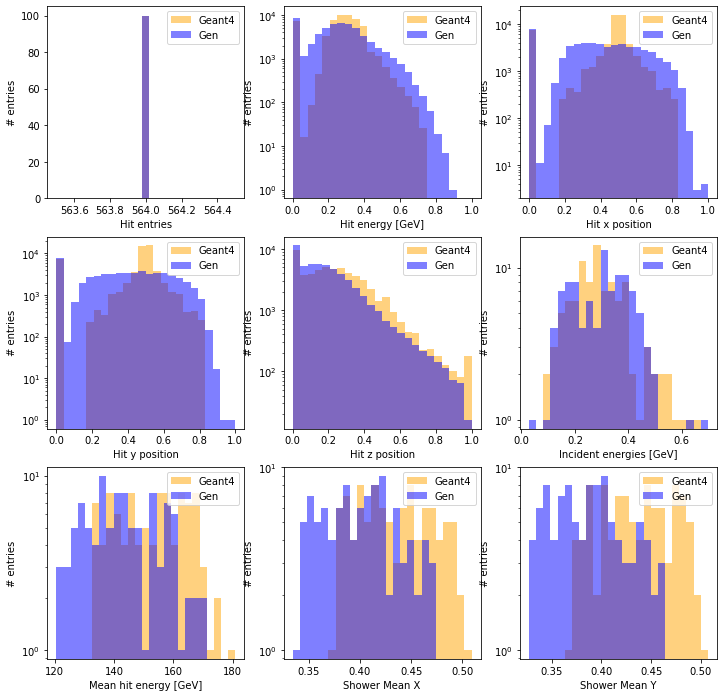

In [7]:
# Ensure plots contain the same number of showers for Geant4 and the generated sample
n_showers_2_gen =  100

# Distributions object for generated files
print(f'Generated inputs')
output_directory = 'sampling_test_ds2_diff_transforms_20240103_1053_output'
plot_file_name = os.path.join(output_directory, 'sample.pt')
custom_data = utils.cloud_dataset(plot_file_name,device=device)
# When providing just cloud dataset, energy_trans_file needs to include full path
dists_gen = util.display.plot_distribution(custom_data, nshowers_2_plot=n_showers_2_gen,padding_value=padding_value)

entries_gen = dists_gen[0]
all_incident_e_gen = dists_gen[1]
all_hit_ine_gen = dists_gen[2]
all_e_gen = dists_gen[3]
all_x_gen = dists_gen[4]
all_y_gen = dists_gen[5]
all_z_gen = dists_gen[6]
average_e_shower_gen = dists_gen[7]
average_x_shower_gen = dists_gen[8]
average_y_shower_gen = dists_gen[9]

print(f'Geant4 inputs')
# Distributions object for Geant4 files
dists = util.display.plot_distribution(files_list_, nshowers_2_plot=n_showers_2_gen,padding_value=padding_value)

entries = dists[0]
all_incident_e = dists[1]
all_hit_ine_geant = dists[2]
all_e = dists[3]
all_x = dists[4]
all_y = dists[5]
all_z = dists[6]
average_e_shower_geant = dists[7]
average_x_shower_geant = dists[8]
average_y_shower_geant = dists[9]

print('Plot # entries')
print(f'entries: {len(entries)}')
print(f'entries_gen: {len(entries_gen)}')

bins=np.histogram(np.hstack((entries,entries_gen)), bins=25)[1]
fig, ax = plt.subplots(3,3, figsize=(12,12))
ax[0][0].set_ylabel('# entries')
ax[0][0].set_xlabel('Hit entries')
ax[0][0].hist(entries, bins, alpha=0.5, color='orange', label='Geant4')
ax[0][0].hist(entries_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[0][0].legend(loc='upper right')

bins=np.linspace(0,1,25)
print('Plot hit energies')
#bins=np.histogram(np.hstack((all_e,all_e_gen)), bins=50)[1]
ax[0][1].set_ylabel('# entries')
ax[0][1].set_xlabel('Hit energy [GeV]')
ax[0][1].hist(all_e, bins, alpha=0.5, color='orange', label='Geant4')
ax[0][1].hist(all_e_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[0][1].set_yscale('log')
ax[0][1].legend(loc='upper right')

print('Plot hit x')
#bins=np.histogram(np.hstack((all_x,all_x_gen)), bins=50)[1]
ax[0][2].set_ylabel('# entries')
ax[0][2].set_xlabel('Hit x position')
ax[0][2].hist(all_x, bins, alpha=0.5, color='orange', label='Geant4')
ax[0][2].hist(all_x_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[0][2].set_yscale('log')
ax[0][2].legend(loc='upper right')

print('Plot hit y')
#bins=np.histogram(np.hstack((all_y,all_y_gen)), bins=50)[1]
ax[1][0].set_ylabel('# entries')
ax[1][0].set_xlabel('Hit y position')
ax[1][0].hist(all_y, bins, alpha=0.5, color='orange', label='Geant4')
ax[1][0].hist(all_y_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[1][0].set_yscale('log')
ax[1][0].legend(loc='upper right')

print('Plot hit z')
#bins=np.histogram(np.hstack((all_z,all_z_gen)), bins=50)[1]
ax[1][1].set_ylabel('# entries')
ax[1][1].set_xlabel('Hit z position')
ax[1][1].hist(all_z, bins, alpha=0.5, color='orange', label='Geant4')
ax[1][1].hist(all_z_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[1][1].set_yscale('log')
ax[1][1].legend(loc='upper right')

print('Plot incident energies')
bins=np.histogram(np.hstack((all_incident_e,all_incident_e_gen)), bins=25)[1]
ax[1][2].set_ylabel('# entries')
ax[1][2].set_xlabel('Incident energies [GeV]')
ax[1][2].hist(all_incident_e, bins, alpha=0.5, color='orange', label='Geant4')
ax[1][2].hist(all_incident_e_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[1][2].set_yscale('log')
ax[1][2].legend(loc='upper right')

print('Plot total deposited hit energy')
bins=np.histogram(np.hstack((average_e_shower_geant,average_e_shower_gen)), bins=25)[1]
#bins=np.linspace(0,100,100)
ax[2][0].set_ylabel('# entries')
ax[2][0].set_xlabel('Mean hit energy [GeV]')
ax[2][0].hist(average_e_shower_geant, bins, alpha=0.5, color='orange', label='Geant4')
ax[2][0].hist(average_e_shower_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[2][0].set_yscale('log')
ax[2][0].legend(loc='upper right')

print('Plot average hit X position')
#bins=np.linspace(0,100,100)
bins=np.histogram(np.hstack((average_x_shower_geant,average_x_shower_gen)), bins=25)[1]
ax[2][1].set_ylabel('# entries')
ax[2][1].set_xlabel('Shower Mean X')
ax[2][1].hist(average_x_shower_geant, bins, alpha=0.5, color='orange', label='Geant4')
ax[2][1].hist(average_x_shower_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[2][1].set_yscale('log')
ax[2][1].legend(loc='upper right')

print('Plot average hit Y position')
bins=np.histogram(np.hstack((average_y_shower_geant,average_y_shower_gen)), bins=25)[1]
#bins=np.linspace(0,100,100)
ax[2][2].set_ylabel('# entries')
ax[2][2].set_xlabel('Shower Mean Y')
ax[2][2].hist(average_y_shower_geant, bins, alpha=0.5, color='orange', label='Geant4')
ax[2][2].hist(average_y_shower_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[2][2].set_yscale('log')
ax[2][2].legend(loc='upper right')

fig.show()

fig_name = os.path.join(output_directory, 'Geant_Gen_comparison.png')
fig.savefig(fig_name)